In [109]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

## Problem 1

In [110]:
data = np.array([[-3, 1], [-2, 1], [-1, -1], [0, 1], [1, -1], [2, 1], [3, 1]])
X, y = data[:,0], data[:,1]
Xp = np.vstack([X, -8./3. * X ** 2 + 2./3. * X ** 4]).T

In [111]:
Xp, y

(array([[-3., 30.],
        [-2.,  0.],
        [-1., -2.],
        [ 0.,  0.],
        [ 1., -2.],
        [ 2.,  0.],
        [ 3., 30.]]),
 array([ 1,  1, -1,  1, -1,  1,  1]))

### (a)

Plot the transformed training data in R2 and draw the optimal decision boundary of the max
margin classifier. You can determine this by inspection (i.e. by hand, without actually doing any
calculations).

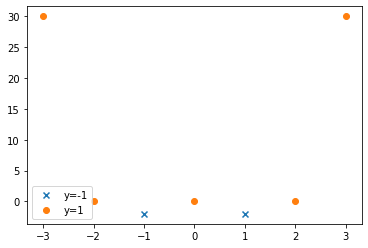

In [112]:
markers = [(-1, "x"), (1, "o")]
for yval, marker in markers:
    plt.scatter(*zip(*Xp[y == yval]), marker=marker, label=f'y={yval}')
plt.legend()
plt.show()

## Problem 2

The objective function is
\begin{equation}
\mathcal{L}(
    \mathbf{X},
    \{\mathbf{\mu}\}^C_{c=1},
    \{\mathbf{r}\}^N_{n=1}
)
=
\sum_{n=1}^N \sum_{c=1}^C r_{nc} (\mathbf{x}_n - \mathbf{\mu}_c)^2
\end{equation}

Furthermore, the update for $r_{nc}$ is
\begin{equation}
r_{nc} = \begin{cases}
    1 & \text{if } c = \text{argmin}_{c'} \| x_n - \mu_{c'}\|   \\
    0 & \text{else} 
\end{cases}
\end{equation}

In [5]:
!mkdir -p data/
!wget -nc https://github.com/harvard-ml-courses/cs181-s20-homeworks/blob/master/hw4/data/large_dataset.npy?raw=true -O data/large_dataset.npy
!wget -nc https://github.com/harvard-ml-courses/cs181-s20-homeworks/blob/master/hw4/data/small_dataset.npy?raw=true -O data/small_dataset.npy
!wget -nc https://github.com/harvard-ml-courses/cs181-s20-homeworks/blob/master/hw4/data/small_dataset_labels.npy?raw=true -O data/small_dataset_labels.npy

File ‘data/large_dataset.npy’ already there; not retrieving.
File ‘data/small_dataset.npy’ already there; not retrieving.
File ‘data/small_dataset_labels.npy’ already there; not retrieving.


In [6]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial import distance
from seaborn import heatmap

# This line loads the images for you. Don't change it! 
large_dataset = np.load("data/large_dataset.npy").astype(np.int64)
small_dataset = np.load("data/small_dataset.npy").astype(np.int64)
small_labels = np.load("data/small_dataset_labels.npy").astype(int)

In [7]:
class KMeans(object):
    # K is the K in KMeans
    def __init__(self, K):
        self.K = K
        self.C = K

    def fit(self, X, iters=100, verbose=False):
        """Does K means clustering with an input array.
        If array has more dimensions than (N, D), then
        we will flatten to shape (batch_size, D)"""
        # Step 1: Randomly generate the means.
        X = X.reshape(X.shape[0], -1)
        self.N, self.D = X.shape  # keep track of num_data and data_dim
        self.mu = np.random.randn(self.C, self.D)
        self.r = np.zeros((self.N, self.C))  # initialize assigned clusters as onehot
        
        for _ in tqdm(range(iters)):
            # Do the update step for r
            closest_clusters = np.linalg.norm(
                np.expand_dims(X, 1).repeat(self.C, axis=1) - self.mu, axis=-1
            ).argmin(axis=-1)
            self.r = np.eye(self.C)[closest_clusters]

            # Do the update step for the clusters mu
            self.mu = (self.r.T @ X) / np.expand_dims(self.r.sum(axis=0), -1)
        
            # See the objective function, should monotonically decrease
            if verbose:
                print(self.objective_function(X, self.mu, self.r))
        
    
    @classmethod
    def objective_function_naive(cls, X, mu, r):
        """Calculates our objective function.
        Assumes the sizes:
            X: (num_data, data_dim)
            mu: (cluster_size, data_dim)
            r: (num_data, cluster_size)
        """
        N, C = X.shape[0], mu.shape[0]
        assert mu.shape[1] == X.shape[1]
        assert mu.shape[0] == r.shape[1]
        assert X.shape[0] == r.shape[0]
        
        total = 0
        for c in range(C):
            for idx in range(N):
                total += r[idx, c] * \
                    (X[idx] - mu[c]).dot(X[idx] - mu[c])
        return total
    
    @classmethod
    def objective_function(cls, X, mu, r):
        """Calculates our objective function.
        Assumes the sizes:
            X: (num_data, data_dim)
            mu: (cluster_size, data_dim)
            r: (num_data, cluster_size)
        """
        N, C = X.shape[0], mu.shape[0]
        assert mu.shape[1] == X.shape[1]
        assert mu.shape[0] == r.shape[1]
        assert X.shape[0] == r.shape[0]
        return (r * np.square(np.linalg.norm(
            np.expand_dims(X, 1).repeat(C, axis=1) - mu, axis=-1))).sum()

    # This should return the arrays for K images. Each image should represent the mean of each of the fitted clusters.
    def get_mean_images(self):
        return self.mu

In [8]:
x = np.random.randn(10, 5)
mu = np.random.randn(3, 5)
r = np.random.randn(10, 3)

r.sum(axis=0, keepdims=True).shape

(1, 3)

In [10]:
test_X = np.random.randn(100, 20)
test_mu = np.random.randn(10, 20)
test_r = np.random.randn(100, 10)

print(KMeans.objective_function_naive(test_X, test_mu, test_r))
print(KMeans.objective_function(test_X, test_mu, test_r))

-1380.1532531500186
-1380.1532531500181


Train 5 different models, each with different restarts.

In [11]:
K = 10
NUM_MODELS = 5

models = []
for _ in range(NUM_MODELS):
    kmeans_model = KMeans(K=K)
    kmeans_model.fit(large_dataset, iters=20)
    models.append(kmeans_model)

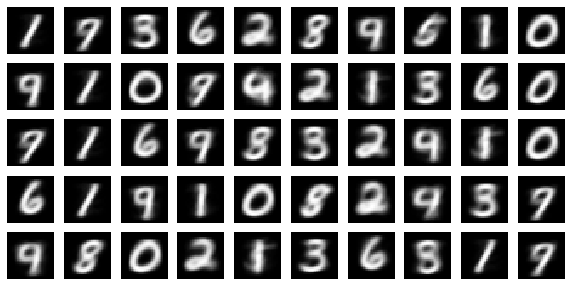

In [12]:
plt.figure(figsize=(K, NUM_MODELS))
plot_counter = 1
for model in models:
    for mat in model.get_mean_images():
        plt.subplot(NUM_MODELS, K, plot_counter)
        plt.imshow(mat.reshape(28, 28), cmap='Greys_r')
        plot_counter += 1
        plt.axis('off')
plt.show()

### 2.4

Do the same thing, except normalize the data.

In [13]:
# make sure to turn any deviations that are 0 into 1
data_mean = large_dataset.mean(axis=0)
data_std = large_dataset.std(axis=0)
data_std[data_std == 0.] = 1.

norm_dataset = (large_dataset - data_mean) / data_std

In [14]:
models = []
for _ in range(NUM_MODELS):
    kmeans_model = KMeans(K=K)
    kmeans_model.fit(norm_dataset, iters=20)
    models.append(kmeans_model)

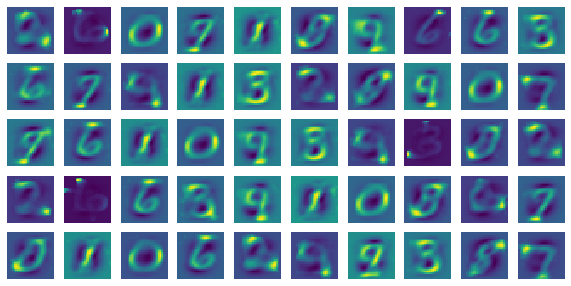

In [15]:
plt.figure(figsize=(K, NUM_MODELS))
plot_counter = 1
for model in models:
    for mat in model.get_mean_images():
        plt.subplot(NUM_MODELS, K, plot_counter)
        plt.imshow(mat.reshape(28, 28))
        plot_counter += 1
        plt.axis('off')
plt.show()

Data whitening isn't invariant w.r.t the L2 norm, as in each pixel location gets scaled differently.
Therefore, the clustering will produce different results.
Note that the clustering would have produced the same results if we had rescaled the pixels by a constant value.

### Problem 2.5

Will implement this in an inefficent way for now.

In [21]:
from scipy.spatial.distance import cdist

We'll use three different metrics between clusters $C$ and $C'$
and $x_k \in C, x_{k'} \in C'$, and have the metric $M(C, C') \to \mathbb{R}$:

* Max Distance: $\text{max}_{k, k'} \| x_k - x_{k'} \| $
* Min Distance: $\text{min}_{k, k'} \| x_k - x_{k'} \| $
* Centroid: $\left\| \left(\frac{1}{|C|}\sum_{c \in C} c\right) - 
    \left(\frac{1}{|C'|}\sum_{c' \in C'} c' \right) \right\| $

In [79]:
class HAC(object):
    def __init__(self, linkage):
        self.linkage = linkage
        self.linkage_map = {
            "centroid": self.centroid_distance,
            "max": self.max_distance,
            "min": self.min_distance,
        }
        if linkage not in self.linkage_map:
            raise RuntimeError("Invalid linkage metric specified")
        self.linkage = self.linkage_map[linkage]
        
    def fit(self, X):
        """Fit the clusters one by one. The different clusters at each timestep will be
        added to the instance variable self.clusters. This starts from the original
        states and ends when we have a single cluster available, and is stored as a list of lists"""
        self.clusters_history = []
        self.X = X 
        self.N, self.D = X.shape
        self.merge_distances = []
        
        # initialize all clusters to be each data point
        self.clusters = [[idx] for idx in range(self.N)]
        # add a copy to the clusters history
        self.clusters_history.append(self.clusters[:])
        
        # Should take N - 1 interations to get to 1 cluster left.
        for _ in tqdm(range(self.N - 1)):
            # Find the smallest two clusters inside the current clusters
            # make a copy of the clusters so we can use list of lists
            metrics = [((idx1, idx2), self.linkage(self.X[c1], self.X[c2]))
                       for idx1, c1 in enumerate(self.clusters)
                       for idx2, c2 in enumerate(self.clusters)
                       if idx1 < idx2]
            smallest_pair, metric_value = min(metrics, key=lambda x: x[-1])
            self.merge_distances.append(metric_value)
            g1, g2 = smallest_pair
            g1, g2 = min(g1, g2), max(g1, g2)
            
            # be careful when removing the pair - remove the larger index first
            new_group = self.clusters[g1] + self.clusters[g2]
            del self.clusters[g2]
            del self.clusters[g1]
            self.clusters.append(new_group)    
            self.clusters_history.append(self.clusters[:])
        
        # In the end, we should only have one cluster left
        assert len(self.clusters) == 1
        
    def return_clusters(self, num_clusters):
        """Returns the state of clusters when there were num_cluster #clusters"""
        try:
            clusters = self.clusters_history[-num_clusters]
            assert len(clusters) == num_clusters
            return clusters
        except IndexError:
            raise RuntimeError("Too many clusters specified")
        
    @classmethod 
    def max_distance(cls, group1, group2):
        """Uses the max_distance method to compute the distance score between two groups.
        Expects the groups to have a batch dimension.
            group1: (group1_size, data_dim)
            group2: (group2_size, data_dim)
        """
        return cdist(group1, group2).max()
    
    @classmethod 
    def min_distance(cls, group1, group2):
        """Uses the min_distance method to compute the distance score between two groups.
        Expects the groups to have a batch dimension.
            group1: (group1_size, data_dim)
            group2: (group2_size, data_dim)
        """
        return cdist(group1, group2).min()
    
    @classmethod 
    def centroid_distance(cls, group1, group2):
        """Uses the centroid method to compute the distance score between two groups.
        Expects the groups to have a batch dimension.
            
        """
        return np.linalg.norm(group1.mean(axis=0) - group2.mean(axis=0))

In [80]:
a = np.random.randn(3, 4)
b = np.random.randn(2, 4)

print(np.linalg.norm(np.expand_dims(a, 1).repeat(2, 1) - b, axis=-1))
cdist(a, b)

[[1.14591223 2.79376248]
 [3.21781156 3.36232307]
 [2.83105468 2.59967306]]


array([[1.14591223, 2.79376248],
       [3.21781156, 3.36232307],
       [2.83105468, 2.59967306]])

In [98]:
hac_metrics = ['max', 'min', 'centroid']
metric_model_map = {}

for metric_type in hac_metrics:   
    model = HAC(metric_type)
    model.fit(small_dataset[:300])
    metric_model_map[metric_type] = model

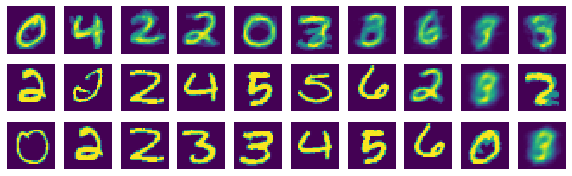

In [108]:
plot_idx = 1
plt.figure(figsize=(10, 3))
for model_type, model in metric_model_map.items():
    for cluster in model.return_clusters(10):
        plt.subplot(3, 10, plot_idx)
        plt.imshow(model.X[cluster].mean(axis=0).reshape(28, 28))
        plot_idx += 1
        plt.axis('off')
plt.show()